# 인공지능 작사가

## 데이터 읽어오기

In [1]:
import numpy as np
import tensorflow as tf
import glob

txt_file_path = './lyricist/data/lyrics/*'
# 경로 지정

txt_list = glob.glob(txt_file_path)
# https://wikidocs.net/3746 
# 해당 경로 폴더의 모든 하위 폴더까지 탐색하여 txt_list에 넣음

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


In [2]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!

In [3]:
import re 

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.

print(preprocess_sentence("This @_is ;;;sample   23423     sentence."))

<start> this is sample sentence . <end>


In [4]:
#############################################

#    # 추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거

corpus = [] #정제된 문장 모으는 곳

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if len(sentence) > 100: continue # 과도하게 긴문장 없애기
    if sentence[-1] == ":": continue
    
    # 정제하기
    preprocessed_sentence = preprocess_sentence(sentence)

    
    # 토큰의 개수가 15개를 넘어가는 문장은 제외
    if len(preprocessed_sentence.split()) > 15: continue
    
    # 담기
    corpus.append(preprocessed_sentence)
    
# 정제된 결과 확인
corpus[:1]

['<start> the first words that come out <end>']

In [5]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   6 248 ...   0   0   0]
 [  2   8   4 ...   0   0   0]
 [  2   4  35 ...   0   0   0]
 ...
 [  2 124 112 ...   0   0   0]
 [  2 124 112 ...   0   0   0]
 [  2 124 112 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fca320329d0>


In [6]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

The first words that come out
And I can see this song will be about you
I can't believe that I can breathe without you
But all I need to do is carry on
The next line I write down
And there's a tear that falls between the pages
I know that pain's supposed to heal in stages
But it depends which one I'm standing on I write lines down, then rip them up
Describing love can't be this tough I could set this song on fire, send it up in smoke
I could throw it in the river and watch it sink in slowly


In [7]:
# tokenizer에 구축된 단어 사전의 인덱스 출력
print(tensor[:5, :]) 

[[  2   6 248 436  15  68  57   3   0   0   0   0   0   0   0]
 [  2   8   4  35  63  41 357  84  27 111   7   3   0   0   0]
 [  2   4  35  16 218  15   4  35 767 257   7   3   0   0   0]
 [  2  33  25   4  92  10  48  26 829  18   3   0   0   0   0]
 [  2   6 331 441   4 759  58   3   0   0   0   0   0   0   0]]


In [8]:
# 정제 후 텐서 크기 출력
print(len(tensor), len(corpus))

156013 156013


In [9]:
# 단어장이 어떻게 구축되었는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2   6 248 436  15  68  57   3   0   0   0   0   0   0]
[  6 248 436  15  68  57   3   0   0   0   0   0   0   0]


In [11]:
# 평가 데이터셋 분리
# 20%를 평가용
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                    tgt_input, 
                                                    test_size=0.2, 
                                                    random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# train 데이터셋
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(train_dataset)

# test 데이터셋
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(test_dataset)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


In [13]:
# 인공지능 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256  # 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 데이터 양이 충분해야함
hidden_size = 1024   # 모델에 얼마나 많은 일꾼을 둘 것인가, 충분한 데이터가 주어져야 배가 산으로 가지 않음
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [14]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
lyricist(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.44549223e-04, -1.15473573e-04, -6.30542418e-05, ...,
         -4.81275529e-05,  3.25414061e-04,  2.03498232e-04],
        [-1.86848993e-04, -2.30316669e-04, -2.25731535e-04, ...,
         -6.46176923e-05,  5.04140393e-04,  3.21763946e-04],
        [-1.03205770e-04, -4.84468270e-04, -1.17466385e-04, ...,
         -4.00223624e-04,  6.36043027e-04,  5.16410160e-04],
        ...,
        [-1.38640136e-03, -4.47364670e-04, -2.00071765e-04, ...,
         -2.70744367e-05,  5.63458947e-04,  1.36734487e-03],
        [-1.38968823e-03, -2.18201923e-04, -5.19401219e-05, ...,
          6.40518032e-04,  7.30469066e-04,  1.37798791e-03],
        [-1.20439660e-03, -3.50640657e-05,  1.76810892e-04, ...,
          1.40748988e-03,  9.31126706e-04,  1.26391207e-03]],

       [[-1.44549223e-04, -1.15473573e-04, -6.30542418e-05, ...,
         -4.81275529e-05,  3.25414061e-04,  2.03498232e-04],
        [-2.94670928e-04, -8.99762235e-05, -2

In [15]:
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = tf.keras.optimizers.Adam()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

lyricist.compile(loss=loss, 
                     optimizer=optimizer, 
                     metrics=['accuracy']) # 정확성 판단

lyrics_history = lyricist.fit(train_dataset, # 훈련 데이터
                                  validation_data=test_dataset, # 평가 데이터
                                  epochs=10)

Epoch 1/10
487/487 [==============================] - 100s 201ms/step - loss: 3.5322 - accuracy: 0.4808 - val_loss: 3.1559 - val_accuracy: 0.5119
Epoch 2/10
487/487 [==============================] - 98s 201ms/step - loss: 3.0327 - accuracy: 0.5202 - val_loss: 2.9604 - val_accuracy: 0.5263
Epoch 3/10
487/487 [==============================] - 98s 202ms/step - loss: 2.8649 - accuracy: 0.5308 - val_loss: 2.8512 - val_accuracy: 0.5338
Epoch 4/10
487/487 [==============================] - 98s 202ms/step - loss: 2.7386 - accuracy: 0.5393 - val_loss: 2.7715 - val_accuracy: 0.5406
Epoch 5/10
487/487 [==============================] - 98s 202ms/step - loss: 2.6322 - accuracy: 0.5470 - val_loss: 2.7075 - val_accuracy: 0.5464
Epoch 6/10
487/487 [==============================] - 98s 202ms/step - loss: 2.5367 - accuracy: 0.5544 - val_loss: 2.6574 - val_accuracy: 0.5517
Epoch 7/10
487/487 [==============================] - 98s 202ms/step - loss: 2.4491 - accuracy: 0.5618 - val_loss: 2.6150 - val_a

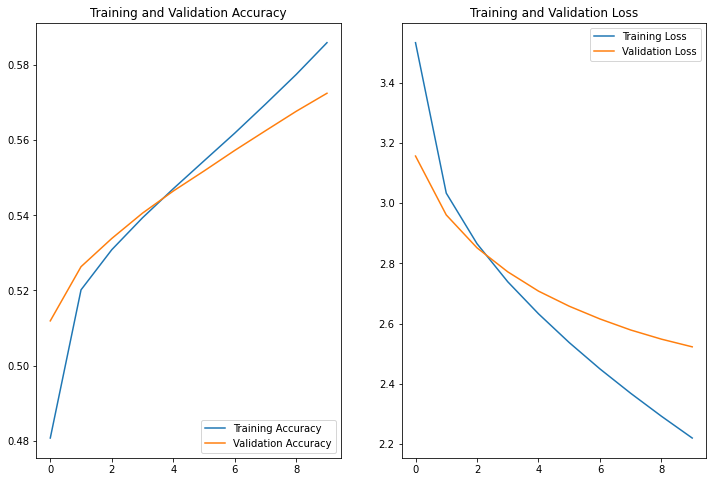

In [17]:
# EX06에서 배운 거 써먹어 보기
import matplotlib.pyplot as plt

acc = lyrics_history.history['accuracy']
val_acc = lyrics_history.history['val_accuracy']

loss = lyrics_history.history['loss']
val_loss = lyrics_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
def generate_text(lyricist, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = lyricist(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [19]:
# 문장 출력
generate_text(lyricist, tokenizer, init_sentence="<start> I ", max_len=20)

'<start> i m a survivor <end> '

# 회고
- 인공지능에서 가장 관심을 갖고 있는 분야가 NLP분야였는데 생각한 것보다 많이 어렵다고 느낀다.
- 문장의 길이를 마음대로 조절할 수 있는 지 궁금해졌다.
- 생각보다 optimizer 시간이 오래걸린다.
- 역시 장비가 좋아야하나 하는 생각이 들었다.

## 데이터
- 데이터 분리하는 부분에서 꽤 오랜 시간을 쏟았다.
- 일단 정리는 했지만 아직 잘 이해가 안가는 부분이 있다.

## 토큰에 대하여
- 토큰을 단어로 보아야 하는지에 대해 개념이 아직 안잡힌것 같다.
- 자연어를 처리할 때 꼭 토큰을 써야 하는가에 대해 여러가지를 찾아봤는데
- 다른 함수를 이용하여 처리하는 경우도 있다는 것을 알았다.
